<a href="https://colab.research.google.com/github/victoriamaina/A-PROJECT-ON-A-LICENSE-RECOGNITION-PLATE-SYSTEM-USING-COMPUTER-VISION./blob/main/License_Plate_Recognition_Using_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A PROJECT ON A LICENSE RECOGNITION PLATE SYSTEM USING COMPUTER VISION.

## 1. Defining the question

To create a model that will be used to recognise and classify number plates.

## 2. Defining Metric of Success.

We will achieve our objectives when;

(a) The model achieves atleast 70% accuracy




## 3. Understanding the Context.

Automatic number plate recognition is a technology used on images to read vehicle registration plates to create vehicle location data.It can be used to store images captured by cameras as well as the text from the licensed plates. Therefore we are creating this automatic system that will help tracking the vehicles by tracing their number plates in the most efficient way.

## 4. Recording the Experimental Design.

The project will be undertaken through the following procedure;

Image Annotation

Loading Data

Base modelling (CNN)

Image Augmentation

Challenging the Model with Keras Transfer Learning (RESNET50)

Conclusion

Recommendations.

## 5. Data Preprocessing

In [ ]:
#Mounting our drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing the required libraries
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Choosing the image size and batch size
image_size = 256
batch_size = 32

batch size is the number of pictures utilzed in one iteration.

In [ ]:
#Creating a dataset from our images
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Annotations",
    shuffle = True,
    image_size = (image_size, image_size),
    batch_size = batch_size
)

Found 218 files belonging to 8 classes.


In [ ]:
#Confirming the class names
class_names = dataset.class_names
class_names

['bodaboda',
 'civilian',
 'customized',
 'gk',
 'kg',
 'ngo',
 'parastatal',
 'tuktuk']

The class names are correct

In [ ]:
#checking number of classes
classes = len(class_names)
print(classes)


8


In [ ]:
#Looking at the shape and batches of the images
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[7 5 7 1 7 1 0 7 0 1 0 1 2 2 1 0 1 6 7 1 1 6 2 4 6 1 1 1 1 6 6 6]


Our batch size is 32 and image size is 256 by 256.

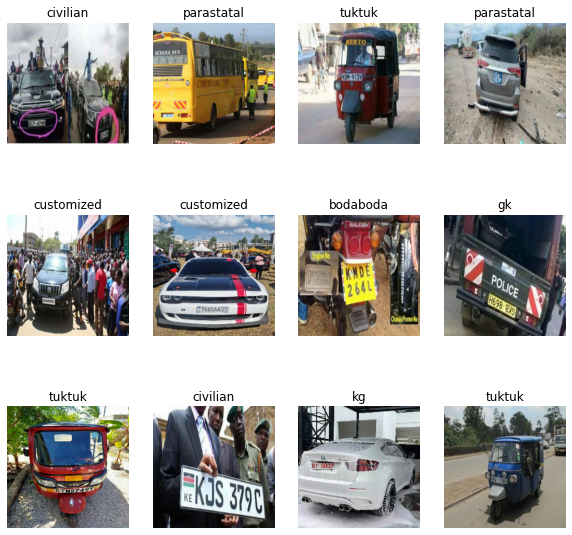

In [ ]:
#Checking if the classes and images are well put
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

the images were correctly classified in their respective classes

In [ ]:
#80% of the result will be used for validation
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/Annotations',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size)

Found 218 files belonging to 8 classes.
Using 175 files for training.


In [ ]:
## 20% of the result will be used for validation
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/Annotations',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size)

Found 218 files belonging to 8 classes.
Using 43 files for validation.


### 5.1 Standardizing the Data

In [ ]:
# The RGB channel values are in the [0,255] range which are large and should standardize the values
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Normalization ensures every image pixel has a similar data distribution to make convergence faster when training the network.

In [ ]:
data_aug = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### 5.2 Configuring Dataset Perfomance

In [ ]:
#Configurations of the perfomance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 6. Training the Model

###6.1 CNN

We will use CNN to extract higher representations for the image content using the keras **Sequential algorithm** which allows us to create models layer by layer.

In [ ]:
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

In [ ]:
def show_metrics(y_true, y_score):
    # True positive
    tp = np.sum(y_true * y_score)
    # False positive
    fp = np.sum((y_true == 0) * y_score)
    # True negative
    tn = np.sum((y_true==0) * (y_score==0))
    # False negative
    fn = np.sum(y_true * (y_score==0))

    # True positive rate (sensitivity or recall)
    tpr = tp / (tp + fn)
    # False positive rate (fall-out)
    fpr = fp / (fp + tn)
    # Precision
    precision = tp / (tp + fp)
    # True negatvie tate (specificity)
    tnr = 1 - fpr
    # F1 score
    f1 = 2*tp / (2*tp + fp + fn)
    # ROC-AUC for binary classification
    auc = (tpr+tnr) / 2
    # MCC
    mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    print("True positive: ", tp)
    print("False positive: ", fp)
    print("True negative: ", tn)
    print("False negative: ", fn)

    print("True positive rate (recall): ", tpr)
    print("False positive rate: ", fpr)
    print("Precision: ", precision)
    print("True negative rate: ", tnr)
    print("F1: ", f1)
    print("ROC-AUC: ", auc)
    print("MCC: ", mcc)

In [ ]:
#Setting layers for the model
num_classes = 8

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(16, activation='softmax'),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
!pip install tensorflow-addons


import tensorflow_addons as tfa 




     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [ ]:
#Setting the parameters of the model
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[tfa.metrics.F1Score(
    num_classes = 8,
    average = 'micro',
    threshold = 0.1,
    name = 'f1_score',
    dtype = None)]
    )

we used parameters **adam** to handle sparse gradients on noisy problem 

and **SparseCategoricalCrossentropy** since our classes are mutually exclusive.

We also incorporated f1 score has our metric since we had class imbalance.

In [ ]:
#Fitting the model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20,   
  verbose=True

)

Epoch 1/20
6/6 [==============================] - 62s 10s/step - loss: 2.0584 - f1_score: 0.2864 - val_loss: 1.9577 - val_f1_score: 0.2403
Epoch 2/20
6/6 [==============================] - 38s 6s/step - loss: 2.0243 - f1_score: 0.2496 - val_loss: 1.9777 - val_f1_score: 0.6689
Epoch 3/20
6/6 [==============================] - 41s 7s/step - loss: 2.0388 - f1_score: 0.6745 - val_loss: 1.9745 - val_f1_score: 0.6689
Epoch 4/20
6/6 [==============================] - 39s 6s/step - loss: 2.0334 - f1_score: 0.6745 - val_loss: 1.9700 - val_f1_score: 0.6689
Epoch 5/20
6/6 [==============================] - 39s 6s/step - loss: 2.0278 - f1_score: 0.6745 - val_loss: 1.9656 - val_f1_score: 0.6689
Epoch 6/20
6/6 [==============================] - 39s 6s/step - loss: 2.0223 - f1_score: 0.6745 - val_loss: 1.9613 - val_f1_score: 0.6689
Epoch 7/20
6/6 [==============================] - 39s 7s/step - loss: 2.0168 - f1_score: 0.6745 - val_loss: 1.9572 - val_f1_score: 0.6689
Epoch 8/20
6/6 [=================

We got an f1 score of 48%

In [ ]:
# Viewing all layers of the networki
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      36896     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)       

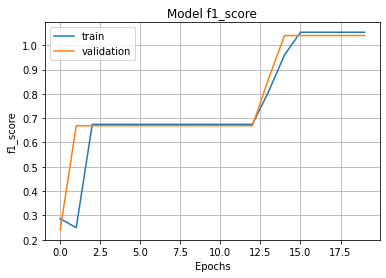

In [ ]:
#Plotting the validation and model accuracy
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.grid()
plt.title('Model f1_score')
plt.ylabel('f1_score')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

the validation score remained constant at 20% 

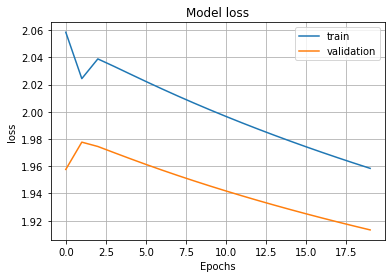

In [ ]:
#model loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Both train and validation losses were in a decline for every subsequent epoch






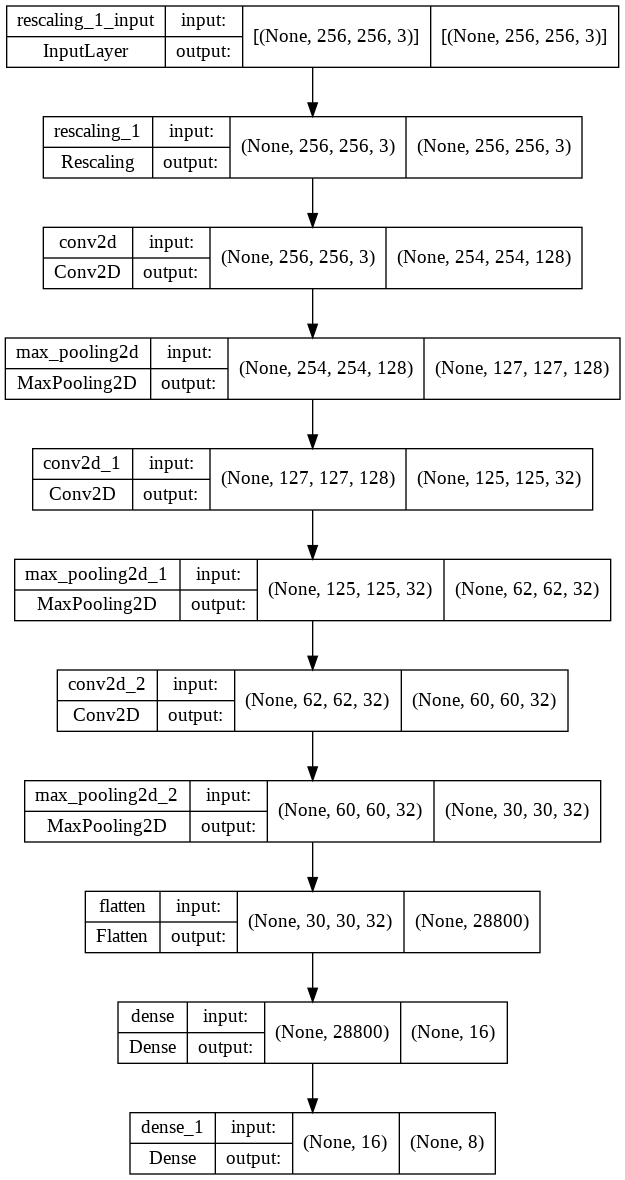

In [ ]:
#Plotting our model
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

##7 Challenging the Solution

###7.1 Image Augmentation

Augmentation involves altering existing data to create some more data for the modelling process to reduce overfitting and improve generalization.

Found 218 images belonging to 8 classes.


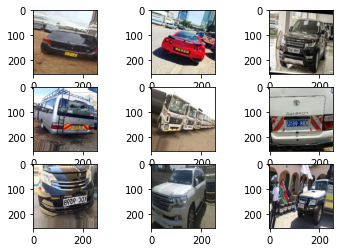

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.1, rotation_range=25, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, horizontal_flip=True)

ite = datagen.flow_from_directory("/content/drive/MyDrive/Annotations", batch_size=1)

for i in range(9):

    # define subplot
    plt.subplot(330 + 1 + i)

    # generate batch of images
    batch = ite.next()

    # convert to unsigned integers for viewing
    image = batch[0]

    image = np.reshape(image,(256,256,3))
#y = np.reshape(y,(2*n,1))
    # plot raw pixel data
    plt.imshow(np.squeeze(image))

# show the figure
plt.show()

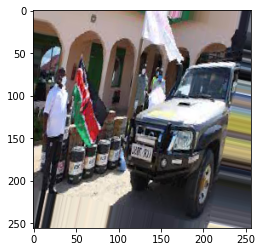

In [ ]:
#Let's retrieve an image from the dataset and use it to demonstrate data augmentation. 
for images, labels in train_ds.take(1):  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    numpy_images = batch[0]

    numpy_images = np.reshape(numpy_images,(256,256,3))
#y = np.reshape(y,(2*n,1))
    # plot raw pixel data
    plt.imshow(np.squeeze(numpy_images))

In [ ]:
#With the shape information deduced, we can bring all images to a common shape:
img_height = 300
img_width = 500

def reshape_image_dataset(dataset: tf.data.Dataset):
    dataset = dataset.map(
        lambda image, label: (tf.image.resize_with_pad(image, target_height=img_height, target_width=img_width), label))
    return dataset
  
train_ds = reshape_image_dataset(train_ds)
val_ds = reshape_image_dataset(val_ds)

In [ ]:
img_width, img_height = 500,500

resize_rescale = tf.keras.Sequential([
          layers.experimental.preprocessing.Resizing(img_width, img_height),
          layers.experimental.preprocessing.Rescaling(1./255)
])

In [ ]:
#create the preprocessing layer and apply it repeatedly to an image to see the horizontal and vertical flips and rotation.
data_aug = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
# add image to batch
image = tf.expand_dims(image,0)

In [ ]:
image.shape

TensorShape([1, 256, 256, 3])

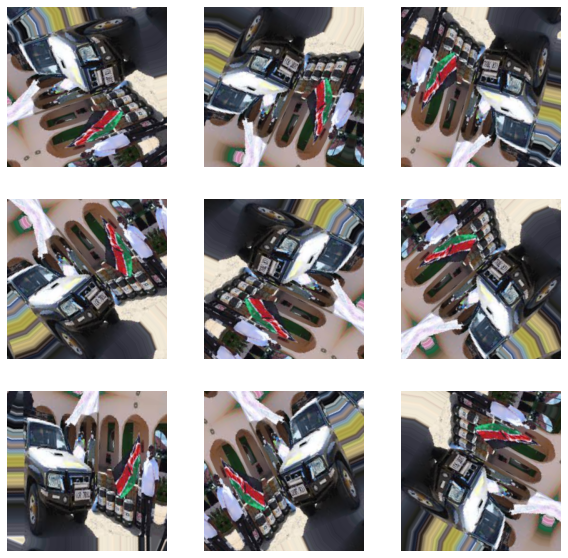

In [ ]:
#plotting the rotations
plt.figure(figsize=(10,10))
for i in range(9):
  aug_image = data_aug(image)
  ax = plt.subplot(3,3,i+1)
  plt.imshow(aug_image[0])
  plt.axis('off')

### options for using preprocessing layers

In [ ]:
#Making it part of your model
model = tf.keras.Sequential([
      resize_rescale,
      data_aug,
      layers.Conv2D(20,3,padding='same',activation='relu'),
      layers.MaxPooling2D(),                           
])

Data augmentation is inactive at test time so input images will only be augmented during calls to model.fit (not model.evaluate or model.predict).

###7.2 Training augmented dataset

In [ ]:
aug_ds = train_ds.map(lambda x,y: (resize_rescale(x, training=True), y))

In [ ]:
#prepocesing the augmented data
batch_size = 30
autotune = tf.data.AUTOTUNE

def prepare(ds,shuffle=False,augment=False):
  # resize and rescale all dataset
  ds = ds.map(lambda x,y: (resize_rescale(x, training=True), y), num_parallel_calls = autotune)
  if shuffle:
    ds = ds.shuffle(1000)
  
  # batch all dataset
  ds = ds.batch(batch_size)

  # use aug only on training set
  if augment:
    ds = ds.map(lambda x,y: (resize_rescale(x, training=True), y),num_parallel_calls = autotune)

  # use buffered prefecting on all ds
  return ds.prefetch(buffer_size=autotune)

In [ ]:
train_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 300, 500, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

###7.3 Preparing New CNN Model

In [ ]:
model = tf.keras.Sequential([
         layers.Conv2D(32,3,padding='same',activation='relu'),
         layers.MaxPooling2D(),
         layers.Conv2D(64,3,padding='same',activation='relu'),
         layers.MaxPooling2D(),
         layers.Conv2D(64,3,padding='same',activation='relu'),
         layers.MaxPooling2D(),
         layers.Flatten(),
         layers.Dense(128, activation='softmax'),
         layers.Dense(classes)                    
])

In [ ]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=[tfa.metrics.F1Score(
    num_classes = 8,
    average = 'micro',
    threshold = 0.1,
    name = 'f1_score',
    dtype = None)]
    )

In [ ]:
#Fitting the model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20,   
  verbose=True

)

Epoch 1/20
6/6 [==============================] - 68s 11s/step - loss: 2.1027 - f1_score: 0.9206 - val_loss: 2.1476 - val_f1_score: 1.0399
Epoch 2/20
6/6 [==============================] - 44s 7s/step - loss: 2.0265 - f1_score: 0.5875 - val_loss: 2.0289 - val_f1_score: 0.4626
Epoch 3/20
6/6 [==============================] - 47s 7s/step - loss: 2.0034 - f1_score: 0.4653 - val_loss: 2.0216 - val_f1_score: 0.4626
Epoch 4/20
6/6 [==============================] - 46s 7s/step - loss: 1.9975 - f1_score: 0.4653 - val_loss: 2.0151 - val_f1_score: 0.4626
Epoch 5/20
6/6 [==============================] - 45s 7s/step - loss: 1.9922 - f1_score: 0.4653 - val_loss: 2.0089 - val_f1_score: 0.4626
Epoch 6/20
6/6 [==============================] - 45s 7s/step - loss: 1.9872 - f1_score: 0.4653 - val_loss: 2.0031 - val_f1_score: 0.4626
Epoch 7/20
6/6 [==============================] - 45s 7s/step - loss: 1.9823 - f1_score: 0.4653 - val_loss: 1.9974 - val_f1_score: 0.4626
Epoch 8/20
6/6 [=================

In [ ]:
history = model.fit(train_ds, validation_data=val_ds,epochs=10)

Epoch 1/10
6/6 [==============================] - 44s 7s/step - loss: 1.9257 - f1_score: 0.4653 - val_loss: 1.9310 - val_f1_score: 0.4626
Epoch 2/10
6/6 [==============================] - 45s 7s/step - loss: 1.9224 - f1_score: 0.4653 - val_loss: 1.9272 - val_f1_score: 0.4626
Epoch 3/10
6/6 [==============================] - 46s 7s/step - loss: 1.9191 - f1_score: 0.4653 - val_loss: 1.9234 - val_f1_score: 0.4626
Epoch 4/10
6/6 [==============================] - 45s 7s/step - loss: 1.9159 - f1_score: 0.4653 - val_loss: 1.9197 - val_f1_score: 0.6689
Epoch 5/10
6/6 [==============================] - 47s 8s/step - loss: 1.9128 - f1_score: 0.6745 - val_loss: 1.9161 - val_f1_score: 0.6689
Epoch 6/10
6/6 [==============================] - 44s 7s/step - loss: 1.9097 - f1_score: 0.6745 - val_loss: 1.9127 - val_f1_score: 0.6689
Epoch 7/10
6/6 [==============================] - 45s 7s/step - loss: 1.9068 - f1_score: 0.7335 - val_loss: 1.9093 - val_f1_score: 0.8608
Epoch 8/10
6/6 [==================

Upon augmentation our model impoved to 53%

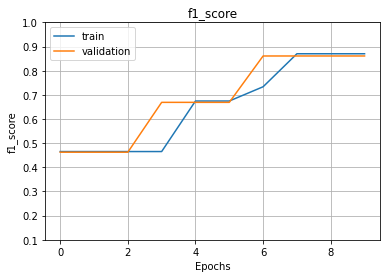

In [ ]:
#f1 score plot
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('f1_score')
plt.ylabel('f1_score')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

there is minimal difference between traina and validation scores

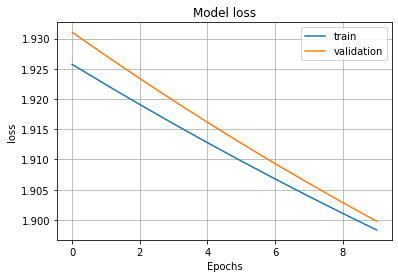

In [ ]:
# f1 loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Both train and validation losses fall as epochs increases.

###7.3 Custom Data Augmentation for RESNET50 Model

In [ ]:
def random_invert_img(x, p=0.6):
  if tf.random.uniform([]) < p:
    x = (255 - x)
  else:
    x
  return x

In [ ]:
def random_inv(factor = 0.65):
  return layers.Lambda(lambda x:random_invert_img(x, factor))

random_invert = random_inv()

In [ ]:
class RandomInv(layers.Layer):
  def __init__(self,factor=0.5,**kwargs):
    super().__init__(**kwargs)
    self.factor = factor
  def call(self, x):
    return random_invert_img(x)

In [ ]:
def showcase(original,augmented):
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,1)
  plt.title('Original')
  plt.imshow(original)
  plt.axis('off')

  plt.subplot(1,2,2)
  plt.title('Augmented')
  plt.imshow(augmented)
  plt.axis('off')

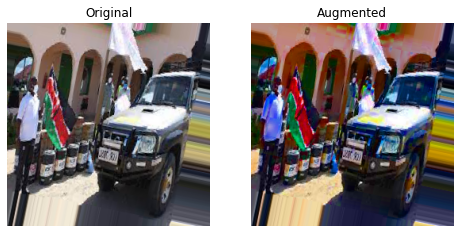

In [ ]:
#saturation
saturated = tf.image.adjust_saturation(numpy_images,3)
showcase(numpy_images, saturated)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


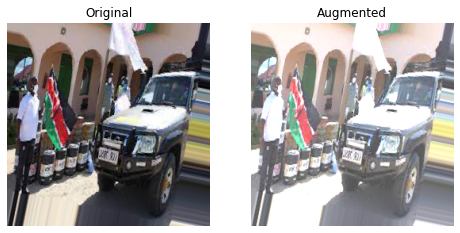

In [ ]:
#brightness
bright = tf.image.adjust_brightness(numpy_images,0.3)
showcase(numpy_images,bright)

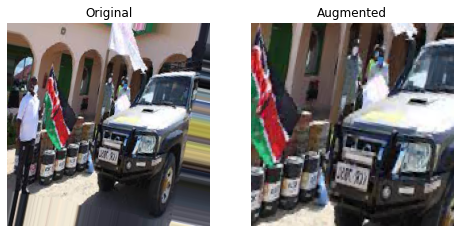

In [ ]:
#Image cropping
crop = tf.image.central_crop(numpy_images,central_fraction=0.6)
showcase(numpy_images,crop)

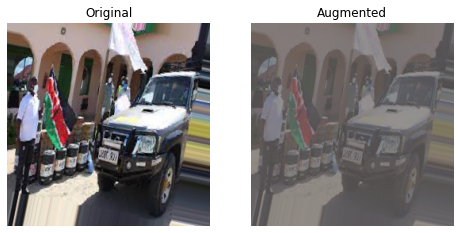

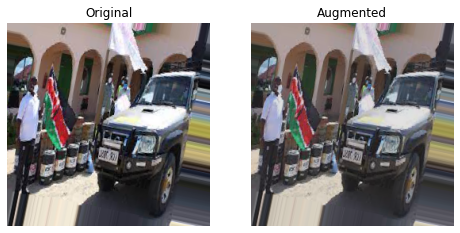

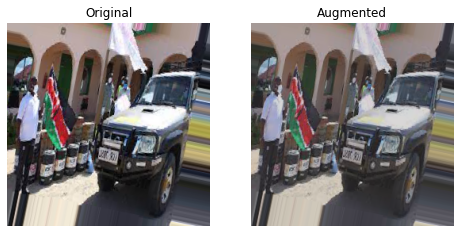

In [ ]:
#Showing results of augmentation
for i in range(3):
  seed = (i,0)
  random_contrast = tf.image.stateless_random_contrast(numpy_images,seed = seed,lower=0.1,upper=0.9)
  showcase(numpy_images,random_contrast)

the a model has to be trained on augmented data, we will use a residual network ResNet50 model

###8. RESNET 50 MODEL

Residual networks (RESNET50) is a neural network used for many computer vision tasks.  You can load a pre-trained version of the network trained on more than a million images from the ImageNet database.

#### Training the model

In [ ]:
import keras

keras.applications.resnet_v2.ResNet50V2()
def create_model(input_shape, num_classes):
    input_layer = tf.keras.layers.Input(shape=input_shape)

    core = keras.applications.resnet_v2.ResNet50V2(
        input_tensor=input_layer, include_top=False, pooling="avg"
    )
    output = tf.keras.layers.Dense(units=num_classes)(core.output)

    return tf.keras.models.Model(input_layer, output)

model = create_model(input_shape=(img_height, img_width, 3), num_classes=len(labels))

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
#TRAINING THE MODEL
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
resnet_model = Sequential()
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                    input_shape=(300,500,3),
                    pooling ='avg', classes=8,
                    weights = 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add (Dense(218, activation='relu'))
resnet_model.add (Dense(8, activation='relu'))

94781440/94765736 [==============================] - 1s 0us/step


Together with the Adam optimizer (used with default settings) and sequential algorithm, we’ll instantiate our metrics and loss objects and then compile the model

In [ ]:
resnet_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 218)               446682    
                                                                 
 dense_6 (Dense)             (None, 8)                 1752      
                                                                 
Total params: 24,036,146
Trainable params: 448,434
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import Adam
#resnet_model.compile(optimizer=Adam(learning_rate= 0.001),loss='categorical_crossenthropy',metrics=['accuracy'])
resnet_model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[tfa.metrics.F1Score(
    num_classes = 8,
    average = 'micro',
    threshold = 0.1,
    name = 'f1_score',
    dtype = None)]
    )

In [ ]:
epochs=20
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
6/6 [==============================] - 124s 20s/step - loss: 2.0346 - f1_score: 0.2872 - val_loss: 2.4197 - val_f1_score: 0.2579
Epoch 2/10
6/6 [==============================] - 102s 17s/step - loss: 2.0183 - f1_score: 0.1276 - val_loss: 2.0679 - val_f1_score: 0.0485
Epoch 3/10
6/6 [==============================] - 101s 17s/step - loss: 1.9059 - f1_score: 0.0313 - val_loss: 1.8748 - val_f1_score: 0.1083
Epoch 4/10
6/6 [==============================] - 101s 17s/step - loss: 1.8242 - f1_score: 0.1279 - val_loss: 1.8771 - val_f1_score: 0.0665
Epoch 5/10
6/6 [==============================] - 100s 17s/step - loss: 1.7902 - f1_score: 0.0613 - val_loss: 1.8209 - val_f1_score: 0.1281
Epoch 6/10
6/6 [==============================] - 104s 18s/step - loss: 1.7634 - f1_score: 0.0754 - val_loss: 1.8091 - val_f1_score: 0.1047
Epoch 7/10
6/6 [==============================] - 99s 17s/step - loss: 1.7269 - f1_score: 0.0791 - val_loss: 1.8545 - val_f1_score: 0.0463
Epoch 8/10
6/6 [=====

RESNET50 achieved an accuracy of 27%

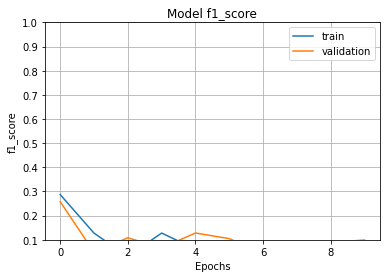

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('Model f1_score')
plt.ylabel('f1_score')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

the graph indicates no case of overfitting

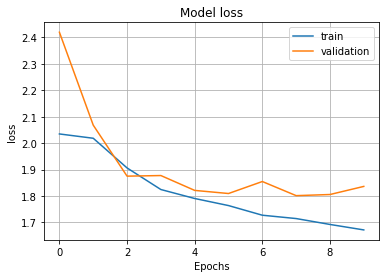

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

The training score keeps falling showing that for the resnet50 the model did not fit well into the training data hence the low f1 score

##8. Model Summaries

In [ ]:
#Creating dataset to display model summaries
import pandas as pd

data = {'Model': ["CNN","Augmented CNN","RESNET50"], 
        'f1_score': [48, 53, 27],
        'Validation f1_score': [59,53,30]
       }

# pass column names in the columns parameter 
df = pd.DataFrame(data)
df

,Model,f1_score,Validation f1_score
0,CNN,48,59
1,Augmented CNN,53,53
2,RESNET50,27,30


In [ ]:
#making a prediction
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
# Helper libraries
import numpy as np
import matplotlib.pyplot as pl
print(tf.__version__)

2.8.0


In [ ]:
# Modify 'test1.jpg' and 'test2.jpg' to the images you want to predict on

from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# dimensions of our images
img_width, img_height = 500, 500

# load the model we saved

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=[tfa.metrics.F1Score(
    num_classes = 8,
    average = 'micro',
    threshold = 0.1,
    name = 'f1_score',
    dtype = None)]
    )

# predicting images
img = image.load_img('/content/ultrashine.jpg', target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
class_names = model.predict(images, batch_size=10)
print (classes)

# predicting multiple images at once
img = image.load_img('/content/benz.jpg', target_size=(img_width, img_height))
y = image.img_to_array(img)
y = np.expand_dims(y, axis=0)

# pass the list of multiple images np.vstack()
images = np.vstack([x, y])
class_names = model.predict(images, batch_size=10)

# print the classes, the images belong to
print(class_names)
#print (class_names[0])
#print (class_names[0][0])

8
[[ -49.53762   -114.08915    100.11154     83.93751    -39.27128
   -62.639565     5.3443837  -21.904058     9.4569435   -7.4299936
   -26.160776   121.0745     120.44989    -86.11989      7.7799206
   -28.126528   -70.42523     -5.9498463 -148.65868    -62.547867
  -176.89787     59.00563     34.707157    68.91126    -39.479206
   108.62329     34.0419      -1.3999963  -82.35089     41.46255
    11.393301   -58.91482  ]
 [-101.82085   -140.6384     107.67346     77.84227    -46.442047
   -61.425323     3.4249716  -60.208687    11.217468   -12.472308
   -46.15856    135.36208    155.82356   -115.244156    12.129332
   -34.490532   -97.16193     18.423754  -154.30806    -60.250507
  -228.81758     73.15766     22.425571    53.32565    -58.574757
   109.57668     44.40675    -13.372967  -111.00474     75.62055
    58.73584    -66.08969  ]]


In [ ]:
#we load and try to display the image that we want to predict.
from google.colab import files
from io import BytesIO
from PIL import Image

uploaded = files.upload()
im = Image.open(BytesIO(uploaded['ultrashine.jpg']))

Saving ultrashine.jpg to ultrashine (1).jpg


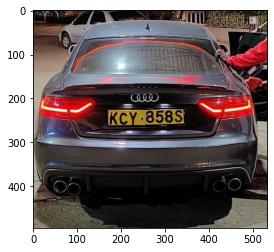

In [ ]:
plt.imshow(im)
plt.show()

In [ ]:
mapped = map([100.11154, 83.93751], dataset)
print(mapped)
print(list(mapped))

TypeError: ignored

# Conclusion
From the performance of the models;
1. Convolutional neural network base model achieved an f1-score of 48%and after augmentation the increased to 53%.
2. Resnet 50 Model achieved an F1-score of 27%.
3. For deployment purposes  better performance will train our            model  using a huge dataset of images for training purposes.

The model accuracy isn't affected by overfitting and underfitting. Rather, it is the size of samples that affects it most. In Kenya, collection of license plates needs one to go through the proper channels. A collaboration with the government, highlighting the many uses of this project will not only improve the model but greatly help in deployment.

# Recommendations

From the performance of our model we therefore recommend the following;
1. The model can be used by the government  to detect and deter criminality. Detect and fine traffic offenders.

2. The government can position cameras in fixed locations on roads with high crime rates.

3. Traffic police can be deployed to work in other departments since the system will have been fixed on roads

4. Adoption of augmented CNN Model.